<h1> Landslide Mapping using FCNN and VHR satellite images using FCN</h1>
Code Author: Kushanav Bhuyan 

***The code is developed for educational project purposes. Codes are not validated with real-world data (YET!!)***


# Load libraries and prepare the dataset

In [20]:
#connect to the googee drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
#Import the required Libraries
import os
import numpy as np
import gdal
import keras
import tensorflow as tf
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage import exposure
from google.colab import drive
import tensorflow as tf

from keras.models import Sequential
from keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Activation, BatchNormalization, Reshape
from keras import backend as K
from keras.optimizers import SGD, Adadelta

import tensorflow.python.keras.backend as K
sess = K.get_session()
from tensorflow.compat.v1.keras.backend import set_session
from keras.layers import LeakyReLU
import pickle
import matplotlib.pyplot as plt 
import sys

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [22]:
#Define File directories
Data_folder = "/content/drive/My Drive/AIA/Project/256"
IMAGE_PATH = os.path.join(Data_folder, "raw")
LABEL_PATH = os.path.join(Data_folder, "gt1")

#Load and prepare the required dataset

In [23]:
#Create list of the VHR images 
image_list={}
for f in sorted(os.listdir(IMAGE_PATH)):
    fdir = os.path.join(IMAGE_PATH, f)
    _, ext = os.path.splitext(f)
    if ext.lower() == ".tif":
        imgtype = f[-9:-4]
        image_data=gdal.Open(fdir)
        bands = [image_data.GetRasterBand(i+1).ReadAsArray() for i in range(image_data.RasterCount)]
        image_list[imgtype] = np.stack(bands, axis=2)

In [24]:
#Create list of Lables
label_list={}
for f in sorted(os.listdir(LABEL_PATH)):
    fdir = os.path.join(LABEL_PATH, f)
    _, ext = os.path.splitext(f)
    if ext.lower() == ".tif":
        imgtype = f[-9:-4]
        label_data=gdal.Open(fdir)
        bands = [label_data.GetRasterBand(i+1).ReadAsArray() for i in range(label_data.RasterCount)]
        label_list[imgtype] = np.stack(bands, axis=2)

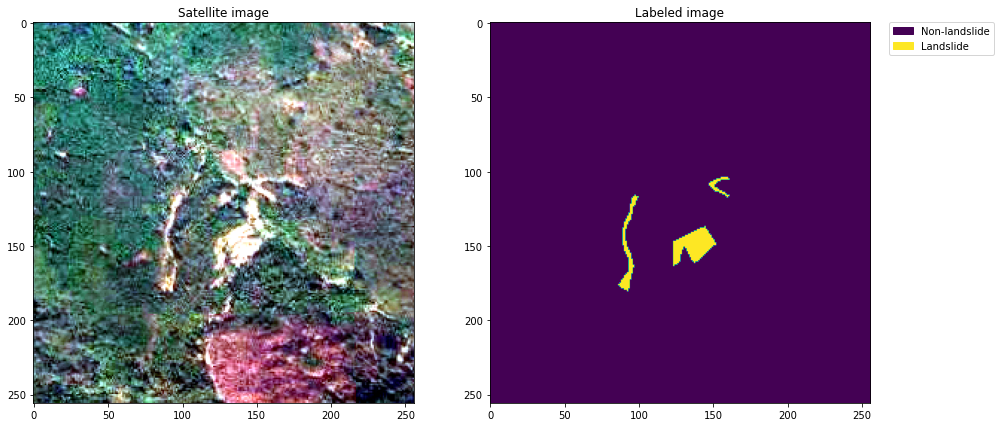

In [32]:
#visualize both images 
sample_image="08"
sample_label="08"

def visualize_data(data,data2):
    f, axarr = plt.subplots(1,2)
    data = data[:, :, 0:3]
    _ = data[:, :, 0].copy()
    data[:, :, 0] = data[:, :, 2]
    data[:, :, 2] = _
    data = data.astype(np.float)
    for i in range(data.shape[2]):
        p2, p98 = np.percentile(data[:, :, i], (2, 98))
        data[:, :, i] = exposure.rescale_intensity(data[:, :, i],
                                                      in_range=(p2, p98))
    axarr[0].imshow(data)
    axarr[0].set_title("Satellite image")

    a=axarr[1]
    values = np.unique(data2.ravel())
    im = axarr[1].imshow(data2[:,:,0])
    a.set_title("Labeled image")
    colors = [im.cmap(im.norm(value)) for value in values] 
    data2 = ["Non-landslide", "Landslide"]
    patches = [mpatches.Patch(color=colors[i], label=j) for i, j in zip(range(len(values)), data2)]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

visualize_data(image_list[sample_image],label_list[sample_label])


In [33]:
#convert data into smaller patches and keras usable formats

PATCHSIZE = 128
NBANDS = image_list["00001"].shape[-1]

def gridwise_sample(imgarray, patchsize):
    """Extract sample patches of size patchsize x patchsize from an image (imgarray) in a gridwise manner.
    """
    nrows, ncols, nbands = imgarray.shape
    patchsamples = np.zeros(shape=(0, patchsize, patchsize, nbands),
                            dtype=imgarray.dtype)
    for i in range(int(nrows/patchsize)):
        for j in range(int(ncols/patchsize)):
            tocat = imgarray[i*patchsize:(i+1)*patchsize,
                             j*patchsize:(j+1)*patchsize, :]
            tocat = np.expand_dims(tocat, axis=0)
            patchsamples = np.concatenate((patchsamples, tocat),
                                          axis=0)
    return patchsamples

Xtrain = np.zeros(shape=(0, PATCHSIZE, PATCHSIZE, NBANDS), dtype=np.float32)
Ytrain = np.zeros(shape=(0, PATCHSIZE, PATCHSIZE, 1), dtype=np.uint8)
# sample each training tile systematically in a gridwise manner
train_areas = ["00000", "00001", "00002","00003","00004","00005", "06","07", "08", "09"]
for area in train_areas:
    X_toadd = gridwise_sample(image_list[area], PATCHSIZE)
    Y_toadd = gridwise_sample(label_list[area], PATCHSIZE)
    Xtrain = np.concatenate((Xtrain, X_toadd), axis=0)
    Ytrain = np.concatenate((Ytrain, Y_toadd), axis=0)
# encode all non-landslide classes as one class
Ytrain[Ytrain!=2] = 1
print("There are %i number of training patches" % (Xtrain.shape[0]))

There are 40 number of training patches


In [34]:
#Check the percentage of landslide pixels with respect to non-landslides
ls_px=len(Ytrain[Ytrain==2])/(len(Ytrain[Ytrain==1])+len(Ytrain[Ytrain==2]))
nonls_px=len(Ytrain[Ytrain==1])/(len(Ytrain[Ytrain==1])+len(Ytrain[Ytrain==2]))
print("Pixel percentage of landslides = " + str(ls_px* 100)) #We can observe that the percentage of landslide pixels are really less (<10%)
print("Pixel percentage of non-landslides = " + str(nonls_px* 100)) 

Pixel percentage of landslides = 3.2992553710937496
Pixel percentage of non-landslides = 96.70074462890625


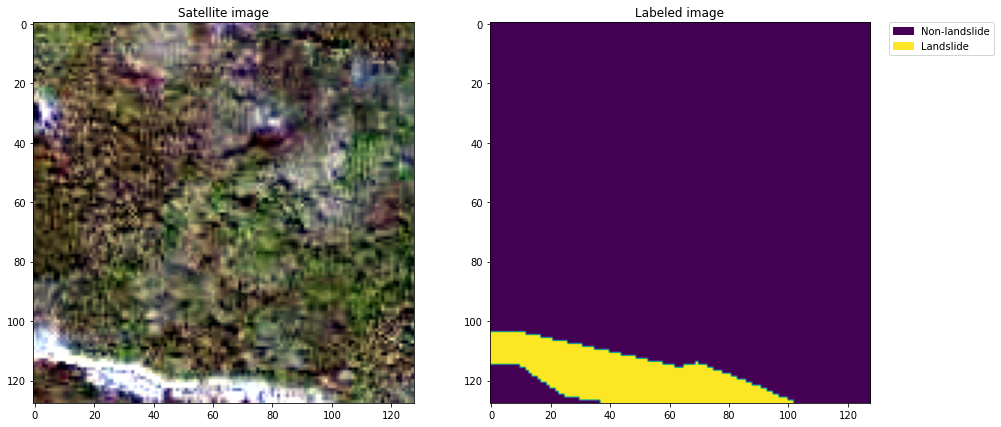

In [37]:
#Visualize the Patches of Image
PATCH_NO = 30
visualize_data(Xtrain[PATCH_NO],Ytrain[PATCH_NO])

**`Convert the label data to categorical as one-hot encoding`**

In [38]:
def to_categorical_4d(y, nc):
    Y = np.zeros((y.shape[0],
                  y.shape[1],
                  y.shape[2],
                  nc),
                  dtype=np.int32)
    for h in range(y.shape[0]):
        for i in range(y.shape[1]):
            for j in range(y.shape[2]):
                if y[h, i, j, 0] != 0:
                    Y[h, i, j, y[h, i, j, 0]-1] = 1
                else:
                    continue
    return Y
# transform target arrays to one-hot encodings
Ytrain = to_categorical_4d(Ytrain, 2)

# Model generation (FCN) and training phase

In [39]:
#Model builder
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
set_session(tf.compat.v1.Session(config=config))

NUMBER_BANDS = 3
NUMBER_CLASSES = 2
NUMBER_EPOCHS = 300  
nclasses=2
def build_FCN(optimizer, nrows, ncols, nbands,nclasses):
    model = keras.models.Sequential()
    model.add(ZeroPadding2D((2, 2), input_shape=(nrows, ncols, nbands)))
    model.add(Convolution2D(
              filters=32,
              kernel_size=(5, 5),
              dilation_rate=(1, 1)))
    model.add(BatchNormalization(axis=3))
    model.add(LeakyReLU(0.1))
    model.add(ZeroPadding2D((2, 2)))
    model.add(MaxPooling2D(
              pool_size=(5, 5),
              strides=(1, 1)
    ))
    model.add(ZeroPadding2D((4, 4)))
    model.add(Convolution2D(
              filters=32,
              kernel_size=(5, 5),
              dilation_rate=(2, 2)
    ))
    model.add(BatchNormalization(axis=3))
    model.add(LeakyReLU(0.1))
    model.add(ZeroPadding2D((4, 4)))
    model.add(MaxPooling2D(
            pool_size=(9, 9),
            strides=(1, 1)
    ))
    model.add(ZeroPadding2D((6, 6)))
    model.add(Convolution2D(
              filters=32,
              kernel_size=(5, 5),
              dilation_rate=(3, 3)
    ))
    model.add(BatchNormalization(axis=3))
    model.add(LeakyReLU(0.1))
    model.add(ZeroPadding2D((6, 6)))
    model.add(MaxPooling2D(
            pool_size=(13, 13),
            strides=(1, 1)
    ))
    model.add(Convolution2D(
              filters=nclasses,
              kernel_size=(1, 1)
    ))
    model.add(keras.layers.Activation(
              activation="softmax"
    ))
    model.compile(loss="categorical_crossentropy", metrics=['accuracy'], optimizer=optimizer)
    return model

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
fcn = build_FCN(opt, PATCHSIZE, PATCHSIZE, NUMBER_BANDS,NUMBER_CLASSES)

fcn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m]) # Use of'adam' optimiser

In [ ]:
fcn.summary()

***Train the model***

In [40]:
def train(model, data, labels):
    hist = model.fit(x=data,
                     y=labels,
                     epochs=NUMBER_EPOCHS,
                     verbose=2
                    )
    return hist

history = train(fcn, Xtrain, Ytrain)

Epoch 1/300
2/2 - 0s - loss: 0.7075 - acc: 0.5547 - f1_m: 0.6817 - precision_m: 0.6817 - recall_m: 0.6817
Epoch 2/300
2/2 - 0s - loss: 0.2622 - acc: 0.9188 - f1_m: 0.9291 - precision_m: 0.9291 - recall_m: 0.9291
Epoch 3/300
2/2 - 0s - loss: 0.1785 - acc: 0.9582 - f1_m: 0.9567 - precision_m: 0.9567 - recall_m: 0.9567
Epoch 4/300
2/2 - 0s - loss: 0.1544 - acc: 0.9552 - f1_m: 0.9566 - precision_m: 0.9566 - recall_m: 0.9566
Epoch 5/300
2/2 - 0s - loss: 0.1277 - acc: 0.9699 - f1_m: 0.9677 - precision_m: 0.9677 - recall_m: 0.9677
Epoch 6/300
2/2 - 0s - loss: 0.1079 - acc: 0.9719 - f1_m: 0.9714 - precision_m: 0.9714 - recall_m: 0.9714
Epoch 7/300
2/2 - 0s - loss: 0.1127 - acc: 0.9649 - f1_m: 0.9636 - precision_m: 0.9636 - recall_m: 0.9636
Epoch 8/300
2/2 - 0s - loss: 0.0931 - acc: 0.9733 - f1_m: 0.9745 - precision_m: 0.9745 - recall_m: 0.9745
Epoch 9/300
2/2 - 0s - loss: 0.0863 - acc: 0.9745 - f1_m: 0.9762 - precision_m: 0.9762 - recall_m: 0.9762
Epoch 10/300
2/2 - 0s - loss: 0.0800 - acc: 0.

# Visualisation of the output curve and saving as weights

Visualize Learning Curve

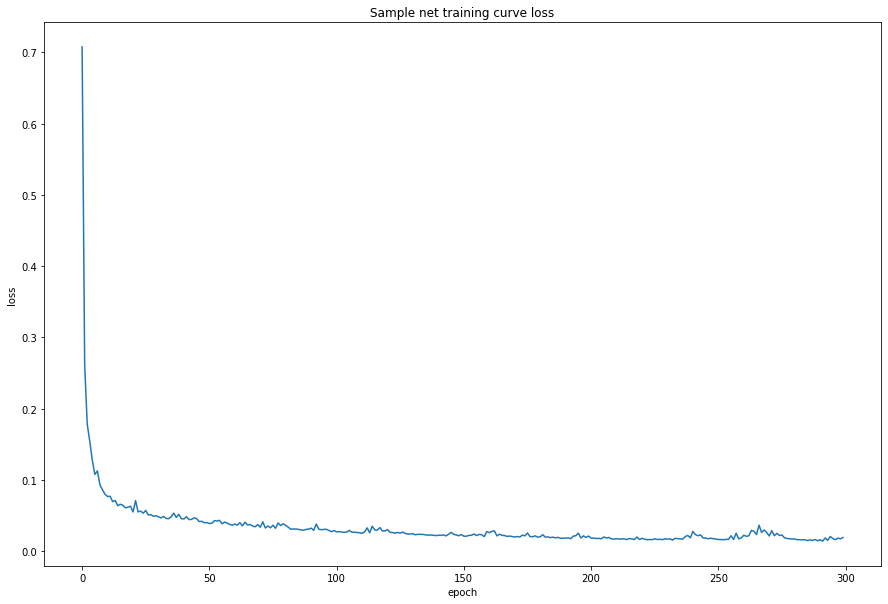

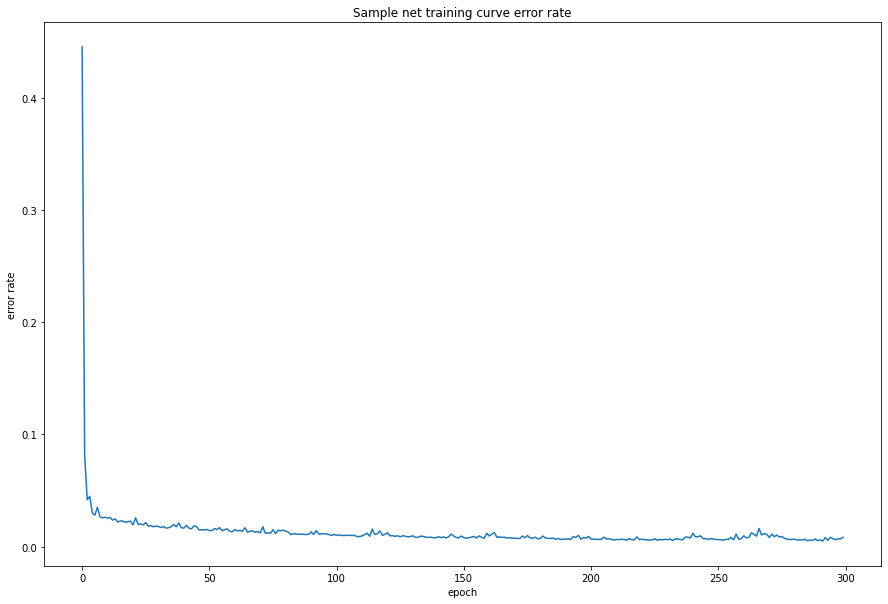

In [41]:
# plot learning curve
plt.plot(history.history["loss"])
plt.title("Sample net training curve loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()
plt.plot(1-np.array(history.history["acc"]))
plt.title("Sample net training curve error rate")
plt.ylabel("error rate")
plt.xlabel("epoch")
plt.show()

Save output

In [42]:
# save the trained network
import imp, h5py
imp.reload(h5py)
model_fname = "/content/drive/My Drive/AIA/Project/256/FCN_train_weights.hdf5"
fcn.save(model_fname)

# Testing phase 

In [43]:
Xtest = image_list["11"] #Test against tile 11 and 12
Ytest = label_list["11"]
cut = 128
overlap = 96

In [44]:
def evaluate_predictions(Xtest,cut, overlap, Ytest):
    """
    Function to predict full tiles strip-wise (as loading whole tiles might not fit in the memory).
    """
    Ytest = Ytest.copy()
    Ytest[Ytest!=2] = 0
    Ytest[Ytest==2] = 1
    ncols, nrows, nbands = Xtest.shape
    Xtest = np.expand_dims(Xtest, axis=0)
    total_map = np.zeros((nrows, ncols), dtype=np.uint8)
    first = True
    last = False
    if nrows%cut==0:
        numstrips = int(nrows/cut)
    else:
        numstrips = int(nrows/cut) + 1
    for i in range(numstrips):
        print("Strip number: %d" % i)
        if first:
            striptop = 0
            stripbottom = overlap
            height = cut
            X_sub = Xtest[:, cut*i-striptop:(cut*i)+height+stripbottom, :, :]
            first = False
        elif (not first) and (cut*(i+1)+1+overlap < nrows):
            striptop = overlap
            stripbottom = overlap
            height = cut
            X_sub = Xtest[:, cut*i-striptop:(cut*i)+height+stripbottom, :, :]
        else:
            print("Last hit!")
            striptop = overlap
            stripbottom = 0
            height = nrows - cut*i
            if (striptop+height)%(4)!=0:
                height = height*4
            X_sub = Xtest[:, -(striptop+height):, :, :]
            last = True        
        sub_nrows = X_sub.shape[1]
        sub_ncols = X_sub.shape[2]
        model = fcn
        
        sub_ns, sub_nb, _, __ = X_sub.shape
        cmap = model.predict_on_batch([X_sub])
        cmap = np.argmax(cmap[0], axis=2)
        if not last:
            total_map[cut*i:cut*i+height, :] = cmap[striptop:striptop+height, 0:total_map.shape[1]]
        else:
            total_map[-(height):, :] = cmap[-(height):, 0:total_map.shape[1]]
    return total_map
predictions_FCN = evaluate_predictions(Xtest, cut, overlap, Ytest)

Strip number: 0
Strip number: 1
Last hit!


In [45]:
import string
from matplotlib import colors
from sklearn.metrics import f1_score, precision_score, recall_score

# set color codes of the classes
_others = [221, 61, 14]
_slums = [200, 199, 219]
ccolors = (_slums, _others)
NROWS, NCOLS, NBANDS = Xtest.shape


def print_map(predictions, idxarray, filename=None, title=None, ccolors=None):
    """Print the classified map.

    Keyword arguments:
    predictions -- the array output labels from the classification
    results
    idxarray -- the array of indices of the classified samples
    to be plotted.
    filename -- the name (with the directory) of the file where to
    write the map.
    ccolors -- an array of tuples containing rgb values for the classes
    Both arrays should match and be arranged accordingly. And the
    index of the color should match the value of the of prediction.
    """
    if predictions.size != idxarray.shape[0]:
        raise ValueError("There should be the same number of " +
                         "predictions and indices.")
    nrows, ncols = np.max(idxarray[:, 0])+1, np.max(idxarray[:, 1])+1
    classifiedmap = np.zeros((nrows, ncols, 3), dtype="uint8")
    idx = 0
    for prediction in predictions:
        classifiedmap[idxarray[idx, 0],
                      idxarray[idx, 1]] = np.asarray(ccolors[prediction])
        idx += 1
    if filename is None:
        fig = plt.figure()
        plt.imshow(classifiedmap)
        if title:
            plt.suptitle(title)
        plt.show()
    else:
        output_raster = gdal.GetDriverByName('GTiff').Create(filename,
                                                             NCOLS,
                                                             NROWS,
                                                             NUMBER_CLASSES,
                                                             gdal.GDT_Byte)
        for i in range(NUMBER_CLASSES):
            output_raster.GetRasterBand(i+1).WriteArray(classifiedmap.astype(np.uint8)[:, :, i])


def get_confusion_matrix(predictions, labels):
    """Compute the confusion matrix.

    Keyword arguments:
    prediction -- the array output labels from the classification
    results
    labels -- the  array of "true" labels from the test set
    Both arrays should match, be arranged accordingly, and
    have non-negative values.
    """
    classes = np.unique(labels)
    nbclasses = classes.size
    if labels.size != predictions.size:
        raise ValueError("There should be the same number of " +
                         "predictions and labels.")
    merged = np.concatenate((predictions.reshape(predictions.size, 1),
                             labels.reshape(labels.size, 1)), axis=1)
    CM = np.zeros((classes[-1] + 1, classes[-1] + 1))
    for c1 in classes:
        for c2 in classes:
            CM[c1, c2] = np.sum(np.logical_and(merged[:, 1] == c1,
                                               merged[:, 0] == c2))
    return CM


def cartesian(arrays, out=None):
    """Utility function to create cartesian image coordinates."""
    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype
    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)
    m = int(n / arrays[0].size)
    out[:, 0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m, 1:])
        for j in range(1, arrays[0].size):
            out[j*m:(j+1)*m, 1:] = out[0:m, 1:]
    return out


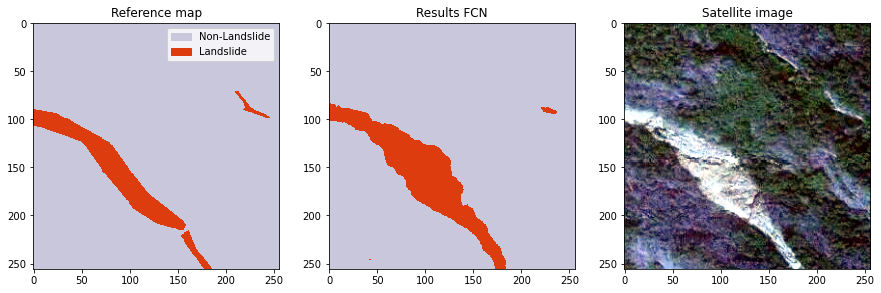

In [46]:
#plot Refrence Map
f, axarr = plt.subplots(1,3)
predictions = predictions_FCN
norm_ccolors = np.array(ccolors)/255.0


fig = axarr[0]
cmap = colors.ListedColormap(norm_ccolors)
bounds=[0,1,2]
norm = colors.BoundaryNorm(bounds, cmap.N)
labels = Ytest[:, :, 0].copy()
labels[labels!=2] = 0
labels[labels==2] = 1
fig.imshow(labels, cmap=cmap, norm=norm, interpolation="nearest", origin="upper")
fig.set_title("Reference map")

ax= axarr[1]
ax.imshow(predictions, cmap=cmap, norm=norm, interpolation="nearest", origin="upper")
ax.set_title("Results FCN")

rectangles = [matplotlib.patches.Rectangle((0, 0), 1, 1, color=norm_ccolors[r]) for r in range(norm_ccolors.shape[0])]
classes = ["Non-Landslide", "Landslide"]
#Create legend from custom artist/label lists
fig.legend(rectangles, classes)
labels = labels.astype("uint8")

data=Xtest
data = data[:, :, 0:3]
_ = data[:, :, 0].copy()
data[:, :, 0] = data[:, :, 2]
data[:, :, 2] = _
data = data.astype(np.float)
for i in range(data.shape[2]):
    p2, p98 = np.percentile(data[:, :, i], (2, 98))
    data[:, :, i] = exposure.rescale_intensity(data[:, :, i],in_range=(p2, p98))

plt_sat=axarr[2]
a=plt_sat.set_title("Satellite image")
_=plt_sat.imshow(data)



In [47]:
CM = get_confusion_matrix(predictions, labels)
print(CM)
OA = np.sum(np.diag(CM))/predictions.size
PA_ls = ((predictions[labels==0]==labels[labels==0]).sum())/(labels[labels==0].size)
PA_nonls = ((predictions[labels==1]==labels[labels==1]).sum())/(labels[labels==1].size)
print("Accuracy metrics of FCN results")
print("Overall Accuracy: %f" % OA)
print("F1 Score: %f" %(f1_score(labels, predictions, average="macro")))
print("PA of Landslide: %f" % PA_ls)
print("PA of Non-Landslide: %f" % PA_nonls)


[[58364.  2874.]
 [  432.  3866.]]
Accuracy metrics of FCN results
Overall Accuracy: 0.949554
F1 Score: 0.552748
PA of Landslide: 0.953068
PA of Non-Landslide: 0.899488


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
